Si potrebbe pensare di utilizzare l'optical flow per migliorare il kamal flter

In [3]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import glob
import numpy as np

from motion_detection_utils import *

In [16]:
def process_frame_differences(ref_frame_bg, frame):
    frame_diff = cv2.subtract(ref_frame_bg, frame)
    frame_diff = cv2.medianBlur(frame_diff, 3)
    # Step 1: Adaptive threshold per gestire le variazioni locali di luminosità
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 11, 3)

    # Step 2: Global threshold per eliminare i pixel di rumore
    _, thresh = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
    #_, thresh = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
    thresh = cv2.medianBlur(thresh, 3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), dtype=np.uint8), iterations=1)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [17]:
def get_bounding_boxes(large_contours):
    bounding_boxes = []
    for cnt in large_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = float(w) / h
        perimeter = cv2.arcLength(cnt, True)
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        # Filter boxes based on conditions
        if 0.2 < aspect_ratio < 1 and circularity > 0.05 and area > 1500:
            bounding_boxes.append((x, y, w, h))
    return bounding_boxes

In [15]:
def load_grayscale_image(file_path):
    try:
        frame = cv2.imread(file_path)
        return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

In [4]:
def initialize_video_writer(output_path, fps, frame_size):
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    return cv2.VideoWriter(output_path, fourcc, fps, frame_size)

In [18]:
def main(frames_dir, output_video):
    ref_frame_bg = load_grayscale_image(f"{frames_dir}/frame0.jpg")
    ref_frame_bg = cv2.resize(ref_frame_bg, (1366, 768) , interpolation= cv2.INTER_LINEAR)
   
    out = initialize_video_writer(output_video, fps=15, frame_size=(1366, 768))
    prev_bounding_boxes = [[0,0,0,0]]
    for i in tqdm(range(1, len(glob.glob1(frames_dir, "*.jpg")) - 1)):
        frame = load_grayscale_image(f"{frames_dir}/frame{i}.jpg")
        frame = cv2.resize(frame, (1366, 768) , interpolation= cv2.INTER_LINEAR)
        if frame is None:
            continue

        if i % 5 == 0 or i == 1:
            large_contours = process_frame_differences(ref_frame_bg, frame)
            bounding_boxes = get_bounding_boxes(large_contours)

        frame_out = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        prev_bounding_boxes.append(bounding_boxes)
        for box in prev_bounding_boxes[-1]:
            x, y, w, h = box
            frame_out = cv2.rectangle(frame_out, (x, y), (x + w, y + h), (0, 0, 200), 2)
        prev_bounding_boxes.pop(0)
                

        out.write(frame_out)
        cv2.imwrite(f"test/frame{i}.jpg", frame_out)  

    out.release()

In [21]:
frames_dir = "preprocessed-frames"
output_video = "human-detection.avi"

In [ ]:
main(frames_dir, output_video)

OPTICAL FLOW STEP

In [5]:
def compute_flow(frame1_path, frame2_path):
    # convert to grayscale
    gray1=load_grayscale_image(frame1_path)
    gray2=load_grayscale_image(frame2_path)

    #gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    #gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)
    return flow

In [6]:
def get_flow_viz(flow):
    """ Obtains BGR image to Visualize the Optical Flow 
        """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

In [11]:
frame_1_path=f"frames/frame150.jpg"
frame_2_path=f"frames/frame155.jpg"

C:\Users\loren\AppData\Local\Temp\ipykernel_1136\3686265441.py:22: RuntimeWarning: divide by zero encountered in log
  ax[2].imshow(np.log(mag/mag.max()), cmap='hsv_r') # try other cmaps 'hsv_r', 'gist_earth_r', 'rainbow_r', 'twilight_r'


Text(0.5, 1.0, 'Log of Dense Optical Flow Magnitude')

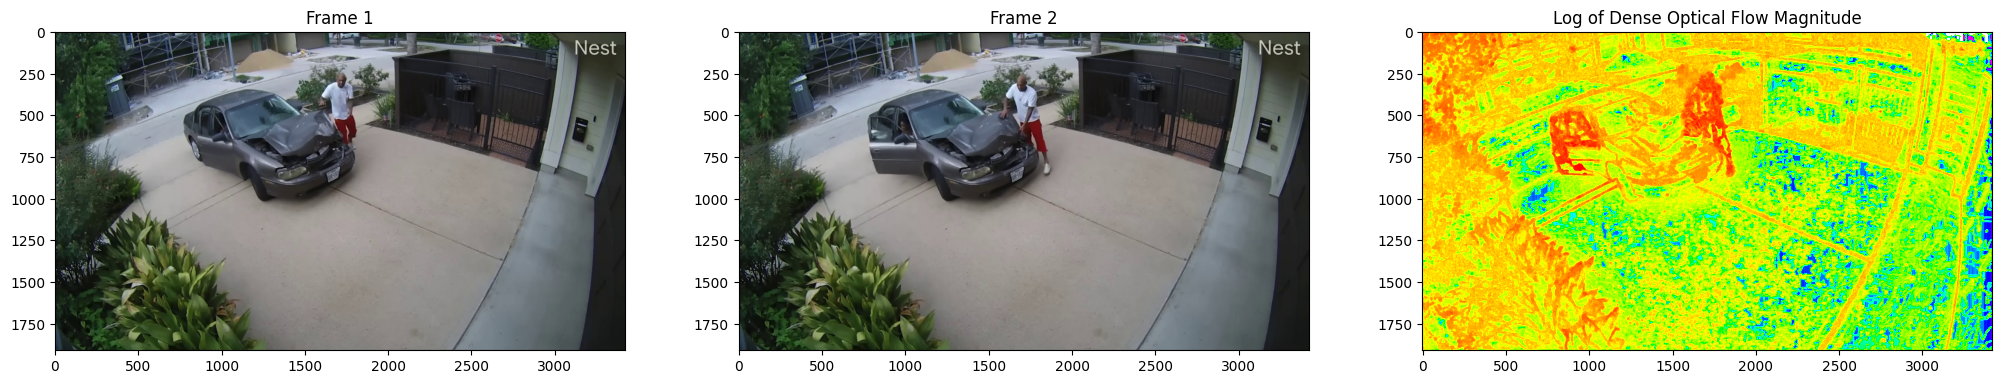

In [ ]:

frame1_bgr_read = cv2.imread(frame_1_path)
frame2_bgr_read = cv2.imread(frame_2_path)

#image1 = load_grayscale_image(f"{frames_dir}/frame150.jpg")
#image2 = load_grayscale_image(f"{frames_dir}/frame155.jpg")

flow=compute_flow(frame_1_path,frame_2_path)

# separate into magntiude and angle
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])


img1_rgb = cv2.cvtColor(frame1_bgr_read, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(frame2_bgr_read, cv2.COLOR_BGR2RGB)

# display
fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(np.log(mag/mag.max()), cmap='hsv_r') # try other cmaps 'hsv_r', 'gist_earth_r', 'rainbow_r', 'twilight_r'
ax[2].set_title('Log of Dense Optical Flow Magnitude')

In [7]:
def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    """ Obtains Detection Mask from Optical Flow Magnitude
        Inputs:
            flow_mag (array) Optical Flow magnitude
            motion_thresh - thresold to determine motion
            kernel - kernal for Morphological Operations
        Outputs:
            motion_mask - Binray Motion Mask
        """
    motion_mask = np.uint8(flow_mag > motion_thresh)*255

    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return motion_mask

In [8]:
min_thresh = 0.3
max_thresh = 1
motion_thresh = np.c_[np.linspace(min_thresh, max_thresh, 1080)].repeat(1920, axis=-1)

In [8]:
def step1_and_step2():
    # compute dense optical flow
    flow = compute_flow(frame_1_path,frame_2_path)

    # separate into magntiude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # get optical flow visualization
    rgb = get_flow_viz(flow)

    '''
    # get variable motion thresh based on prior knowledge of camera position
    motion_thresh = np.c_[np.linspace(0.3, 1, 1080)].repeat(1920, axis=-1)
    '''

    # get variable motion thresh based on prior knowledge of camera position
    height, width = mag.shape[:2] 
    motion_thresh = np.c_[np.linspace(0.3, 1, height)].repeat(width, axis=-1)

    # get motion mask
    mask = get_motion_mask(mag, motion_thresh=motion_thresh)

    # display
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(mask, cmap='gray')
    ax[0].set_title("Motion Mask")
    ax[1].imshow(rgb*50) # scale RGB to see the noise
    ax[1].set_title("Dense Optical Flow")
    return mask, ang

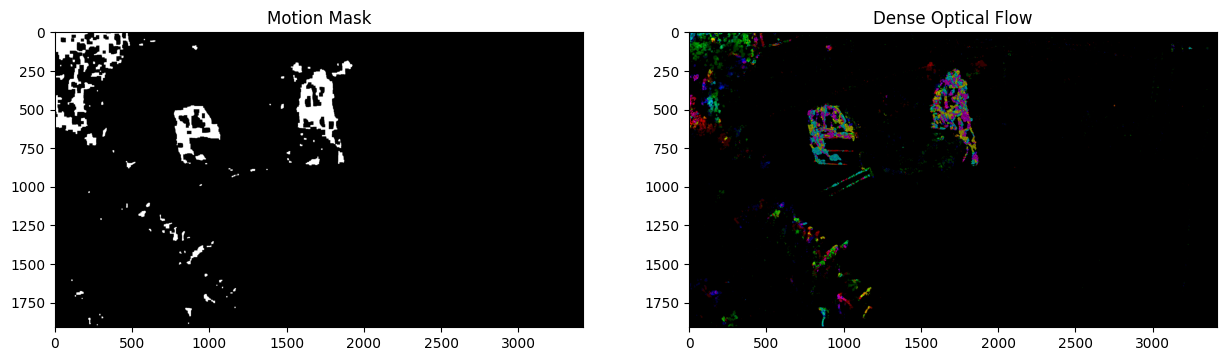

In [30]:
mask, ang= step1_and_step2()

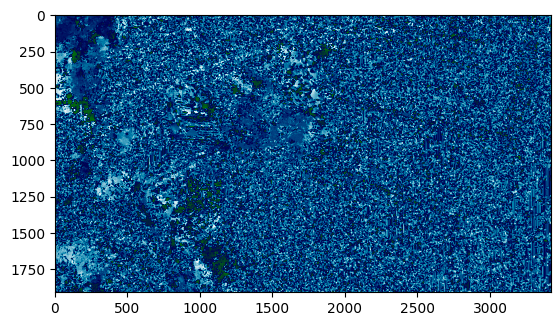

In [31]:
plt.imshow(ang, cmap='ocean') # 'gist_earth_r', 'rainbow_r', 'twilight_r'

In [37]:
def get_contour_detections_adv(mask, ang=ang, angle_thresh=2, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the
        mask. Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            angle_thresh - threshold for flow angle standard deviation
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores 
                        [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                    cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                    cv2.CHAIN_APPROX_TC89_L1)
    temp_mask = np.zeros_like(mask) # used to get flow angle of contours
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        # get area of contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        # get flow angle inside of contour
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh):
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

Text(0.5, 1.0, 'Detected Movers')

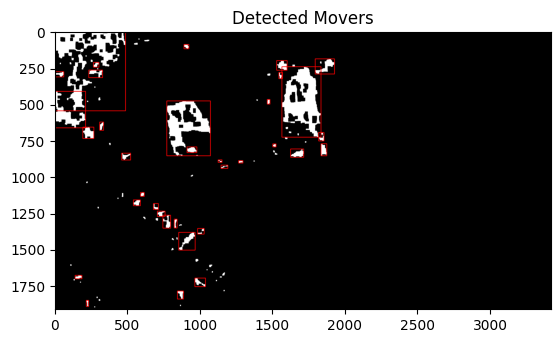

In [ ]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

###CON ADV IL RISULTATO É PRATICAMENTE IDENTICO CI IMPIEGA 5 VOLTE TANTO###
###SI POTREBBE LASCIARE COME IMPLEMENTAZIONE E DIRE CHE IL GIOCO NON VALE LA CANDELA###

#detections = get_contour_detections_adv(mask, ang, angle_thresh=2, thresh=400)
detections = get_contour_detections(mask, thresh=400)

# separate bboxes and scores
bboxes = detections[:, :4]
scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers")

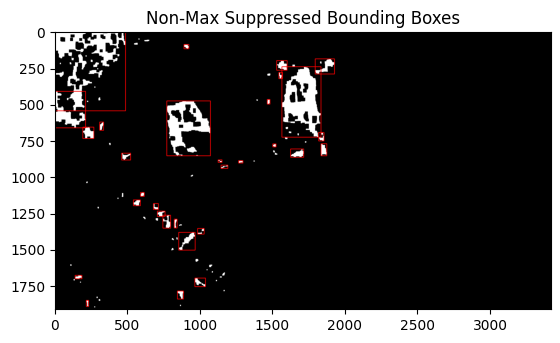

In [40]:
#Non-Maximal Supression

nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)

mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes")

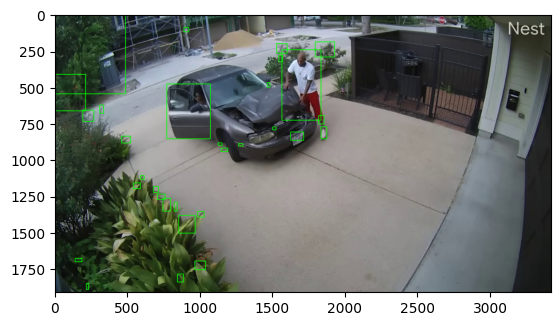

In [41]:
frame2 = img2_rgb.copy()
draw_bboxes(frame2, nms_bboxes)
plt.imshow(frame2)

In [9]:
def get_detections(frame1, frame2, motion_thresh=1, bbox_thresh=400, nms_thresh=0.1, mask_kernel=np.ones((7,7), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            motion_thresh - Minimum flow threshold for motion
            bbox_thresh - Minimum threshold area for declaring a bounding box 
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            mask_kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # get optical flow
    flow = compute_flow(frame1, frame2)

    # separate into magntiude and angle
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    motion_mask = get_motion_mask(mag, motion_thresh=motion_thresh, kernel=mask_kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, thresh=bbox_thresh)
    #SI POTREBBE PENSARE DI USARE IL get_contour_detections_adv

    if len(detections) == 0:
        return np.zeros((0, 5), dtype=np.float32)
    
    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, threshold=nms_thresh)

In [63]:
#frame1_bgr_read = cv2.imread(frame_1_path)
#frame2_bgr_read = cv2.imread(frame_2_path)

#image1 = load_grayscale_image(f"{frames_dir}/frame150.jpg")
#image2 = load_grayscale_image(f"{frames_dir}/frame155.jpg")

out=get_detections(f"frames/frame155.jpg",f"frames/frame1.jpg")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [10]:
import glob

In [20]:
def main_with_optical_flow(frames_dir, output_video):
    #ref_frame_bg = load_grayscale_image(f"{frames_dir}/frame0.jpg")
    #ref_frame_bg = cv2.resize(ref_frame_bg, (1366, 768) , interpolation= cv2.INTER_LINEAR)
    prev_bounding_boxes = [[0,0,0,0]]


    out = initialize_video_writer(output_video, fps=15, frame_size=(3420,1910))

    # get variable motion thresh based on prior knowledge of camera position
    #height, width = mag.shape[:2] 
    height=1910
    width=3420
    motion_thresh = np.c_[np.linspace(0.3, 1, height)].repeat(width, axis=-1)
    kernel = np.ones((7,7), dtype=np.uint8)
    #                                                   prima era len -1
    #for i in tqdm(range(1, len(glob.glob1(frames_dir, "*.jpg")))):
    #for i in tqdm(range(151, 250)):
    for i in tqdm(range(100, 250)):
        #frame = load_grayscale_image(f"{frames_dir}/frame{i}.jpg")
        #frame = cv2.resize(frame, (1366, 768) , interpolation= cv2.INTER_LINEAR)
        frame1_bgr_path=f"{frames_dir}/frame{i-1}.jpg"
        frame2_bgr_path=f"{frames_dir}/frame{i}.jpg"
        frame1_bgr = cv2.imread(frame1_bgr_path)
        frame2_bgr = cv2.imread(frame2_bgr_path)

        if frame1_bgr is None or frame2_bgr is None:
            continue

        if i % 10 == 0 or i == 1:
            # get detections
            detections = get_detections(frame1_bgr_path, 
                                frame2_bgr_path, 
                                motion_thresh=motion_thresh, 
                                bbox_thresh=400, 
                                nms_thresh=0.1, 
                                mask_kernel=kernel)
            # draw bounding boxes on frame
            #draw_bboxes(frame2_bgr, detections)
            #large_contours = process_frame_differences(ref_frame_bg, frame)
            #bounding_boxes = get_bounding_boxes(large_contours)

        # draw bounding boxes on frame
        if detections.size!=0:
            prev_bounding_boxes.append(detections)
            draw_bboxes(frame2_bgr, detections)

            '''
            for box in prev_bounding_boxes[-1]:
                x, y, w, h = box
                frame_out = cv2.rectangle(frame_out, (x, y), (x + w, y + h), (0, 0, 200), 2)
            '''
            prev_bounding_boxes.pop(0)
        #draw_bboxes(frame2_bgr, detections)
        '''
        frame_out = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        prev_bounding_boxes.append(bounding_boxes)
        for box in prev_bounding_boxes[-1]:
            x, y, w, h = box
            frame_out = cv2.rectangle(frame_out, (x, y), (x + w, y + h), (0, 0, 200), 2)
        prev_bounding_boxes.pop(0)
        '''

        out.write(frame2_bgr)
        cv2.imwrite(f"test/frame{i}.jpg", frame2_bgr)  

    out.release()

In [21]:
output_video = "human-detection-optical-flow.avi"
frames_dir="frames"
main_with_optical_flow(frames_dir, output_video)

100%|██████████| 749/749 [11:29<00:00,  1.09it/s]


FAST ALGO

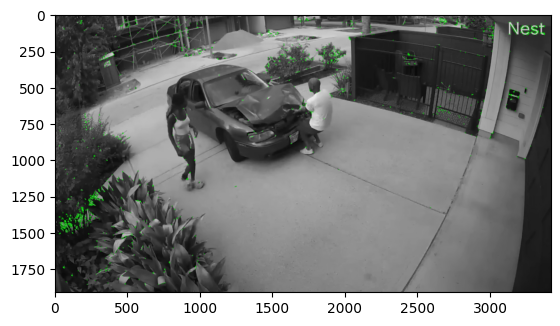

In [6]:
frames_dir = "preprocessed-frames"
# convert roi to grayscale, SIFT Algorithm works with grayscale images
image = cv2.imread(f"{frames_dir}/frame217.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Initialize the FAST detector and BRIEF descriptor extractor
fast = cv2.FastFeatureDetector_create(threshold=20)
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

# detect keypoints
keypoints_1 = fast.detect(gray, None)
# descriptors
keypoints_1, descriptors_1 = brief.compute(gray, keypoints_1)

# draw keypoints for visualizing
keypoints_image = cv2.drawKeypoints(gray, keypoints_1, outImage=None, color=(0, 255, 0))
# display keypoints
plt.imshow(keypoints_image,cmap="gray")

In [9]:
def load_grayscale_image(file_path):
    try:
        frame = cv2.imread(file_path)
        return cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

In [12]:
# matcher object
bf = cv2.BFMatcher()

# Variables for FPS calculation
frame_count = 0
start_time = time.time()

for i in tqdm(range(1, len(glob.glob1(frames_dir, "*.jpg")) - 1)):
    #load the frame
    frame = load_grayscale_image(f"{frames_dir}/frame{i}.jpg")
    frame = cv2.resize(frame, (1366, 768) , interpolation= cv2.INTER_LINEAR)
    
    # Detect keypoints using FAST
    keypoints_2 = fast.detect(frame, None)

    # Compute descriptors using BRIEF
    keypoints_2, descriptors_2 = brief.compute(frame, keypoints_2)

    frame = load_grayscale_image(f"{frames_dir}/frame{i}.jpg")
    """
        Compare the keypoints/descriptors extracted from the 
        first frame(from target object) with those extracted from the current frame.
    """
    if descriptors_2 is  not None:
        matches =bf.match(descriptors_1, descriptors_2)
    
        for match in matches:
            
            # queryIdx gives keypoint index from target image
            query_idx = match.queryIdx
                
            # .trainIdx gives keypoint index from current frame 
            train_idx = match.trainIdx
                
            # take coordinates that matches
            pt1 = keypoints_1[query_idx].pt
                
            # current frame keypoints coordinates
            pt2 = keypoints_2[train_idx].pt
                
            # draw circle to pt2 coordinates , because pt2 gives current frame coordinates
            cv2.circle(frame,(int(pt2[0]),int(pt2[1])),5,(255,0,0),-1)
    
        # Calculate and display FPS
        frame_count += 1
        elapsed_time = time.time() - start_time
        fps = frame_count / elapsed_time
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)


        cv2.imshow("coordinate_screen",frame) 
    
    
        k = cv2.waitKey(5) & 0xFF # after drawing rectangle press esc   
        if k == 27:
            cv2.destroyAllWindows()
            break
    else:
        break

cv2.destroyAllWindows()

 15%|█▌        | 114/748 [00:26<02:28,  4.27it/s]
